In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Generate synthetic linear data
np.random.seed(42)
N = 100  # Number of data points
x = np.random.uniform(0, 10, N)
true_w0 = 2.0  # True intercept
true_w1 = 0.5  # True slope
noise = np.random.normal(0, 1, N)
y = true_w0 + true_w1 * x + noise  # Observations with noise

# Define log-likelihood (Gaussian likelihood with variance sigma_y^2)
def log_likelihood(w, x, y, sigma_y=1.0):
    w0, w1 = w
    y_pred = w0 + w1 * x
    return -0.5 * np.sum(((y - y_pred) / sigma_y) ** 2) - N * np.log(sigma_y * np.sqrt(2 * np.pi))

# Define log-prior (Gaussian priors on w0 and w1 with variance sigma_prior^2)
def log_prior(w, sigma_prior=10.0):
    return -0.5 * np.sum((w / sigma_prior) ** 2)

# Log-posterior is the sum of log-likelihood and log-prior
def log_posterior(w, x, y, sigma_y=1.0, sigma_prior=10.0):
    return log_likelihood(w, x, y, sigma_y) + log_prior(w, sigma_prior)

# Gradient of the log-likelihood
def grad_log_likelihood(w, x, y, sigma_y=1.0):
    w0, w1 = w
    y_pred = w0 + w1 * x
    grad_w0 = np.sum((y - y_pred) / sigma_y**2)
    grad_w1 = np.sum((y - y_pred) * x / sigma_y**2)
    return np.array([grad_w0, grad_w1])

# Gradient of the log-prior (Gaussian prior)
def grad_log_prior(w, sigma_prior=10.0):
    return -w / sigma_prior**2

# Gradient of the log-posterior
def grad_log_posterior(w, x, y, sigma_y=1.0, sigma_prior=10.0):
    return grad_log_likelihood(w, x, y, sigma_y) + grad_log_prior(w, sigma_prior)

# Hamiltonian Monte Carlo algorithm
def hmc(log_posterior, grad_log_posterior, x, y, num_samples, epsilon, L, initial_w, sigma_y=1.0, sigma_prior=10.0):
    samples = []
    current_w = initial_w
    
    for i in range(num_samples):
        # Step 1: Sample momentum from a standard normal distribution
        current_momentum = np.random.normal(0, 1, size=current_w.shape)

        # Step 2: Simulate Hamiltonian dynamics using leapfrog method
        new_w = current_w.copy()
        new_momentum = current_momentum.copy()

        # Half step for momentum
        new_momentum -= 0.5 * epsilon * grad_log_posterior(new_w, x, y, sigma_y, sigma_prior)
        
        # Full steps for position and momentum
        for _ in range(L):
            # Full step for position
            new_w += epsilon * new_momentum
            # Full step for momentum (except at last step)
            if _ != L - 1:
                new_momentum -= epsilon * grad_log_posterior(new_w, x, y, sigma_y, sigma_prior)
        
        # Half step for momentum (last step)
        new_momentum -= 0.5 * epsilon * grad_log_posterior(new_w, x, y, sigma_y, sigma_prior)

        # Step 3: Compute the Hamiltonians for the current and proposed states
        current_hamiltonian = -log_posterior(current_w, x, y, sigma_y, sigma_prior) + 0.5 * np.sum(current_momentum ** 2)
        proposed_hamiltonian = -log_posterior(new_w, x, y, sigma_y, sigma_prior) + 0.5 * np.sum(new_momentum ** 2)

        # Step 4: Metropolis-Hastings acceptance criterion
        acceptance_prob = np.exp(current_hamiltonian - proposed_hamiltonian)
        if np.random.uniform(0, 1) < acceptance_prob:
            current_w = new_w  # Accept new position

        # Store the sample
        samples.append(current_w)

    return np.array(samples)

In [3]:
# HMC parameters
num_samples = 2000  # Number of samples to generate
epsilon = 0.01  # Smaller step size for the leapfrog integrator
L = 10  # Larger number of leapfrog steps to ensure good exploration
initial_w = np.array([1.0, 0.5])  # Initial guess for w0 and w1


In [4]:
%%time

# Run HMC
samples = hmc(log_posterior, grad_log_posterior, x, y, num_samples, epsilon, L, initial_w)

# Extract samples for w0 and w1
w0_samples = samples[:, 0]
w1_samples = samples[:, 1]

CPU times: user 491 ms, sys: 10.1 ms, total: 501 ms
Wall time: 488 ms


In [5]:
np.mean(w0_samples), np.mean(w1_samples)

(1.0, 0.5)

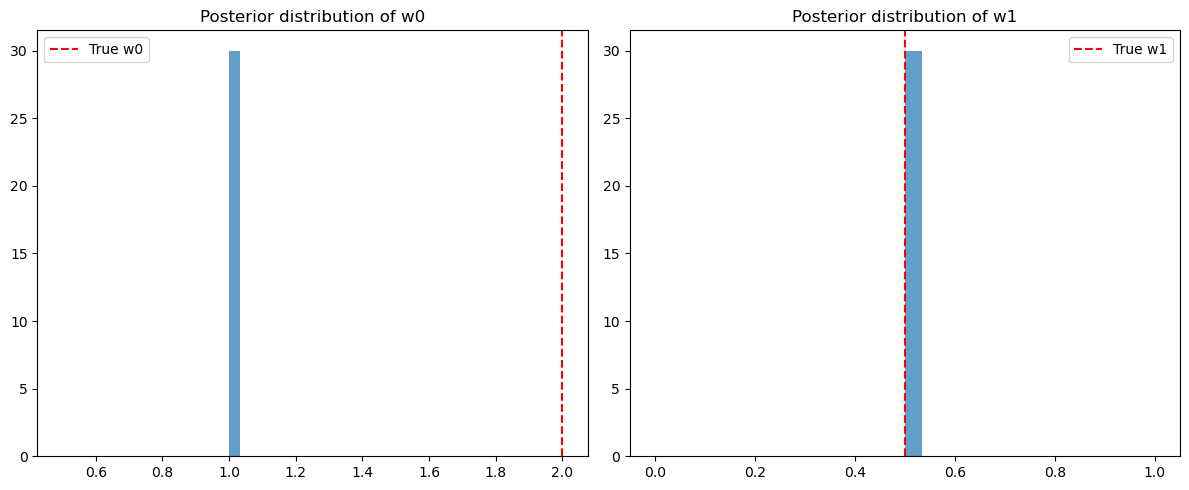

In [6]:
# Plot posterior distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(w0_samples, bins=30, density=True, alpha=0.7)
plt.axvline(true_w0, color='r', linestyle='--', label='True w0')
plt.title('Posterior distribution of w0')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(w1_samples, bins=30, density=True, alpha=0.7)
plt.axvline(true_w1, color='r', linestyle='--', label='True w1')
plt.title('Posterior distribution of w1')
plt.legend()

plt.tight_layout()
plt.show()

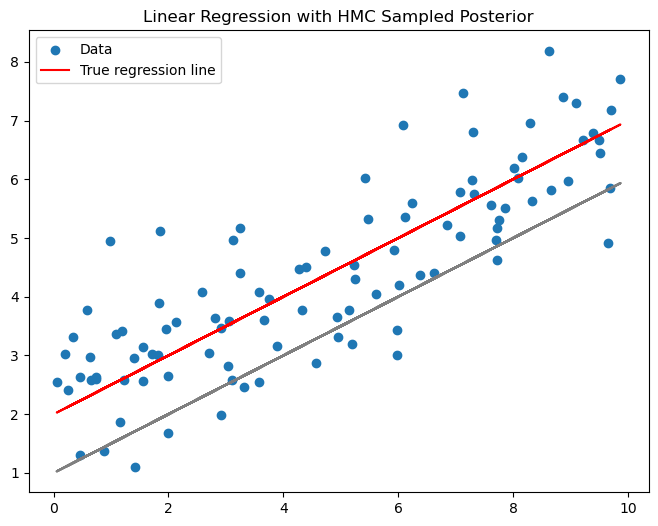

In [7]:
# Plot regression line with posterior samples
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data')
plt.plot(x, true_w0 + true_w1 * x, label='True regression line', color='r')
for i in range(0, len(w0_samples), 100):  # Plot sampled regression lines
    plt.plot(x, w0_samples[i] + w1_samples[i] * x, color='gray', alpha=0.2)
plt.title('Linear Regression with HMC Sampled Posterior')
plt.legend()
plt.show()

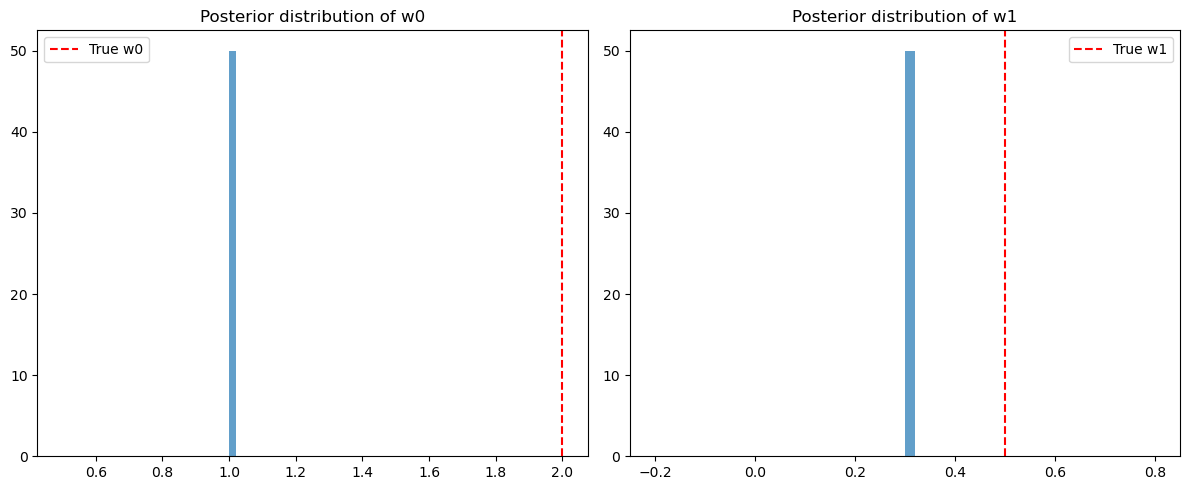

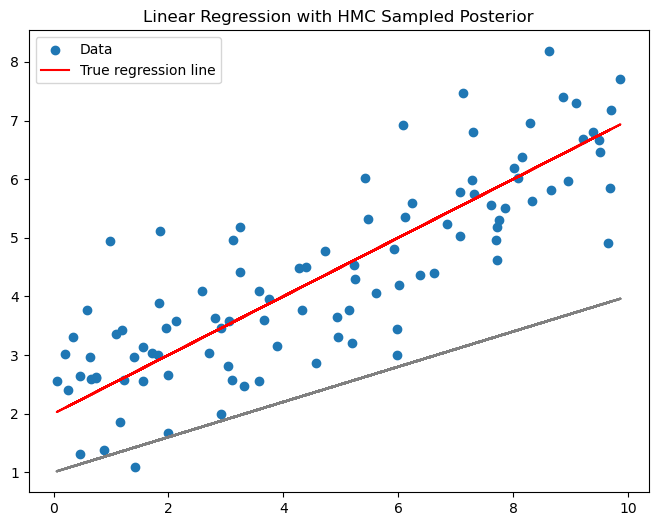

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic linear data
np.random.seed(42)
N = 100  # Number of data points
x = np.random.uniform(0, 10, N)
true_w0 = 2.0  # True intercept
true_w1 = 0.5  # True slope
noise = np.random.normal(0, 1, N)
y = true_w0 + true_w1 * x + noise  # Observations with noise

# Define log-likelihood (Gaussian likelihood with variance sigma_y^2)
def log_likelihood(w, x, y, sigma_y=1.0):
    w0, w1 = w
    y_pred = w0 + w1 * x
    return -0.5 * np.sum(((y - y_pred) / sigma_y) ** 2) - N * np.log(sigma_y * np.sqrt(2 * np.pi))

# Define log-prior (Gaussian priors on w0 and w1 with variance sigma_prior^2)
def log_prior(w, sigma_prior=10.0):
    return -0.5 * np.sum((w / sigma_prior) ** 2)

# Log-posterior is the sum of log-likelihood and log-prior
def log_posterior(w, x, y, sigma_y=1.0, sigma_prior=10.0):
    return log_likelihood(w, x, y, sigma_y) + log_prior(w, sigma_prior)

# Gradient of the log-likelihood
def grad_log_likelihood(w, x, y, sigma_y=1.0):
    w0, w1 = w
    y_pred = w0 + w1 * x
    grad_w0 = np.sum((y - y_pred) / sigma_y**2)
    grad_w1 = np.sum((y - y_pred) * x / sigma_y**2)
    return np.array([grad_w0, grad_w1])

# Gradient of the log-prior (Gaussian prior)
def grad_log_prior(w, sigma_prior=10.0):
    return -w / sigma_prior**2

# Gradient of the log-posterior
def grad_log_posterior(w, x, y, sigma_y=1.0, sigma_prior=10.0):
    return grad_log_likelihood(w, x, y, sigma_y) + grad_log_prior(w, sigma_prior)

# Hamiltonian Monte Carlo algorithm
def hmc(log_posterior, grad_log_posterior, x, y, num_samples, epsilon, L, initial_w, sigma_y=1.0, sigma_prior=10.0):
    samples = []
    current_w = initial_w
    
    for i in range(num_samples):
        # Step 1: Sample momentum from a standard normal distribution
        current_momentum = np.random.normal(0, 1, size=current_w.shape)

        # Step 2: Simulate Hamiltonian dynamics using leapfrog method
        new_w = current_w.copy()
        new_momentum = current_momentum.copy()

        # Half step for momentum
        new_momentum -= 0.5 * epsilon * grad_log_posterior(new_w, x, y, sigma_y, sigma_prior)
        
        # Full steps for position and momentum
        for _ in range(L):
            # Full step for position
            new_w += epsilon * new_momentum
            # Full step for momentum (except at last step)
            if _ != L - 1:
                new_momentum -= epsilon * grad_log_posterior(new_w, x, y, sigma_y, sigma_prior)
        
        # Half step for momentum (last step)
        new_momentum -= 0.5 * epsilon * grad_log_posterior(new_w, x, y, sigma_y, sigma_prior)

        # Step 3: Compute the Hamiltonians for the current and proposed states
        current_hamiltonian = -log_posterior(current_w, x, y, sigma_y, sigma_prior) + 0.5 * np.sum(current_momentum ** 2)
        proposed_hamiltonian = -log_posterior(new_w, x, y, sigma_y, sigma_prior) + 0.5 * np.sum(new_momentum ** 2)

        # Step 4: Metropolis-Hastings acceptance criterion
        acceptance_prob = np.exp(current_hamiltonian - proposed_hamiltonian)
        if np.random.uniform(0, 1) < acceptance_prob:
            current_w = new_w  # Accept new position

        # Store the sample
        samples.append(current_w)

    return np.array(samples)

# HMC parameters
num_samples = 2000  # Number of samples to generate
epsilon = 0.01  # Step size for the leapfrog integrator (adjusted for stability)
L = 50  # Number of leapfrog steps to ensure good exploration
initial_w = np.array([1.0, 0.3])  # Start closer to true values for stability

# Run HMC
samples = hmc(log_posterior, grad_log_posterior, x, y, num_samples, epsilon, L, initial_w)

# Extract samples for w0 and w1
w0_samples = samples[:, 0]
w1_samples = samples[:, 1]

# Plot posterior distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(w0_samples, bins=50, density=True, alpha=0.7)
plt.axvline(true_w0, color='r', linestyle='--', label='True w0')
plt.title('Posterior distribution of w0')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(w1_samples, bins=50, density=True, alpha=0.7)
plt.axvline(true_w1, color='r', linestyle='--', label='True w1')
plt.title('Posterior distribution of w1')
plt.legend()

plt.tight_layout()
plt.show()

# Plot regression line with posterior samples
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data')
plt.plot(x, true_w0 + true_w1 * x, label='True regression line', color='r')
for i in range(0, len(w0_samples), 100):  # Plot sampled regression lines
    plt.plot(x, w0_samples[i] + w1_samples[i] * x, color='gray', alpha=0.2)
plt.title('Linear Regression with HMC Sampled Posterior')
plt.legend()
plt.show()
